In [ ]:
import gym_battleship
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.dqn import CnnPolicy
from gym_battleship.environments.battleship import CHANNEL_MAP
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
import os
from typing import Callable
import imageio
from heuristic_agent import HeuristicAgent
from random_agent import RandomAgent


In [ ]:
%load_ext autoreload
%autoreload 2

### Pull the DQN Model from Git LFS (Large File Storage)

In [ ]:
!git lfs pull --include="dqn_models/dqn_model_9/dqn-9.zip"

### Load helper functions for DQN

In [ ]:
def make_battleship_cnn(features_dim: int, hidden_layer1: int, hidden_layer2: int):
    """
        Factory function to create a custom CNN feature exxtractor for the battleship state space representation 
        (a 3-channel 10x10 matrix), using the specified hyperparameters below. 
        
        Args: 
            features_dim = length of the final vector outputted by the feature extractor
            hidden_layer1 = number of nodes in first hidden layer
            hidden_layer2 = number of nodes in second hidden layer
    """
    class BattleshipCNN(BaseFeaturesExtractor):
        def __init__(self, observation_space, features_dim=features_dim):
            super().__init__(observation_space, features_dim)

            n_channels = observation_space.shape[0]  

            self.cnn = nn.Sequential(
                nn.Conv2d(n_channels, hidden_layer1, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_layer1, hidden_layer2, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Flatten()
            )

            with th.no_grad():
                sample = th.zeros((1, n_channels, 10, 10))
                sample_out = self.cnn(sample)
                conv_output_dim = sample_out.shape[1]

            self.linear = nn.Sequential(
                nn.Linear(conv_output_dim, features_dim),
                nn.ReLU()
            )

        def forward(self, obs):
            return self.linear(self.cnn(obs))
    
    return BattleshipCNN


In [ ]:
def masked_predict(model, obs):
    """
        Choose the action with highest Q-value among legal actions
    """
    
    obs_tensor = th.as_tensor(obs).unsqueeze(0).float()
    
    with th.no_grad():
        q_values = model.q_net(obs_tensor)
        
    legal_mask = (obs[CHANNEL_MAP.LEGAL_MOVE.value, :, :] == 0).flatten()
    
    # set illegal actions to very negative Q-value
    q_values_masked = q_values.clone()
    q_values_masked[0, ~legal_mask] = -float('inf')
    action = q_values_masked.argmax(dim=1).item()

    return action, q_values

In [ ]:
def get_q_values(model, obs):
    """Get Q-values for all 100 possible actions given the current state"""
    obs_tensor = th.as_tensor(obs).unsqueeze(0).float()
    
    with th.no_grad():
        q_values = model.q_net(obs_tensor)

    return q_values

In [ ]:
def plot_q_value_heatmap(q_values, title="Q-Value Heatmap", image=False):
    """
        Generates a heatmap of the q-values for all 100 possible actions given the current state of the board. 
    """
    q_vals = q_values[0].cpu().numpy()
    
    grid = np.zeros((10, 10))
    for i in range(100):
        row = i // 10
        col = i % 10
        grid[row, col] = q_vals[i]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(grid, cmap='coolwarm', aspect='auto')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Q-Value', rotation=270, labelpad=20)
    
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(10))
    ax.set_yticklabels(np.arange(10))
    
    ax.set_xticks(np.arange(10) - 0.5, minor=True)
    ax.set_yticks(np.arange(10) - 0.5, minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(title)
    
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, f'{grid[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    
    if image:
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        img = img[:, :, :3]
        plt.close(fig)
        return img
    else:
        plt.show()
        return grid

In [ ]:
def plot_histogram(ratios, title="Histogram", x_label="X axis", y_label="Y axis", save_path=None):
    """
    Create a histogram of hit-to-miss ratios for a model
        Args:
            ratios: list of ratios (floats) to plot
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.hist(ratios, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    mean_ratio = np.mean(ratios)
    median_ratio = np.median(ratios)
    ax.axvline(mean_ratio, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_ratio:.3f}')
    ax.axvline(median_ratio, color='green', linestyle='--', linewidth=2, label=f'Median: {median_ratio:.3f}')
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150)
    
    plt.show()
    plt.close(fig)

In [ ]:
def plot_action_distribution(action_dict, title="Action Distribution", x_label="Action (Grid Position)", y_label="Frequency", display=True, save_path=None):
    """
    Create a histogram showing the distribution of actions taken
    
    Args:
        action_dict: Dictionary mapping action (int) to frequency (int)
        title: Title for the plot
        x_label: Label for x-axis
        y_label: Label for y-axis
        save_path: Optional path to save the figure
    """
    if not action_dict:
        print("No action distribution data to plot")
        return
    
    actions = sorted(action_dict.keys())
    frequencies = [action_dict[action] for action in actions]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.bar(actions, frequencies, edgecolor='black', alpha=0.7, color='steelblue')
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, alpha=0.3, axis='y')
    
    
    total_actions = sum(frequencies)
    mean_freq = np.mean(frequencies)
    ax.axhline(mean_freq, color='red', linestyle='--', linewidth=2, 
               label=f'Mean Frequency: {mean_freq:.1f}')
    ax.legend()
    
    if len(actions) <= 100:
        for i, (action, freq) in enumerate(zip(actions, frequencies)):
            if freq > mean_freq * 1.5:
                ax.text(action, freq, str(freq), ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150)
    
    if display:
        plt.show()
    plt.close(fig)

In [ ]:
def record_video(env, model, out_directory, fps=30):
  """
    Records a video (.gif) of a single game played by the model in the environment,
    saving both the board state and Q-value heatmap side by side.
  """
  images = []
  obs, _ = env.reset()
  
  # get initial board image and q-values
  img = env.unwrapped.render(mode="image")
  initial_q_values = get_q_values(model, obs)
  heatmap_img = plot_q_value_heatmap(initial_q_values, title="Q-Value Heatmap for next move", image=True)
  combined_img = np.concatenate((img, heatmap_img), axis=1)
  images.append(combined_img)
  
  while True:
    action, _ = masked_predict(model, obs)
    obs, _, terminated, truncated, _ = env.step(int(action))
    img = env.unwrapped.render(mode="image")
    new_q_values = get_q_values(model, obs)
    heatmap_img = plot_q_value_heatmap(new_q_values, title="Q-Value Heatmap for next move", image=True)
    
    # combine the board image and q-value heatmap side by side
    combined_img = np.concatenate((img, heatmap_img), axis=1)
    images.append(combined_img)
    
    if terminated or truncated: 
      break
  
  imageio.mimsave(out_directory, images, fps=fps)

In [78]:

def run_games(model, env, num_games=1000, mask=True, root_dir=None): 
    """
        Evaluates a model in a specific environment environment for a specified number of games.
        Args:
            model: Trained RL model
            env: Gym environment
            num_games: Number of games to play for evaluation
            mask: Whether to use action masking during evaluation
            root_dir: Path to the folder where all plots will be saved
    """
    env.reset()
    num_lost = 0
    num_wins = 0
    num_steps = 0
    total_reward = 0
    num_hits = 0
    num_misses = 0
    action_distributions = []
    total_action_distribution = {}
    num_moves_distribution = []
    hit_to_miss_ratios = []
    sample_freq = num_games / 5

    for game in range(1, num_games + 1):
        obs, info = env.reset()
        sampling_action_distribution = True if (game % sample_freq == 0) else False
        action_distributions.append({}) if sampling_action_distribution else None
        game_hits = 0
        game_misses = 0
        
        # edge case for heuristic and random agent: need to reset it at the start of each game because it maintains internal state
        if isinstance(model, HeuristicAgent): 
            model = HeuristicAgent(env, skip_invalid_actions=True)
        elif isinstance(model, RandomAgent):
            model = RandomAgent(skip_invalid_actions=True)
        
        for _ in range(110):
            if mask:
                action, _ = masked_predict(model, obs)
            else:
                action, _ = model.predict(obs)
                action = int(action)
            
            # log the action taken in action_distributions dictionary for histogram later
            if sampling_action_distribution:
                action_distributions[-1][action] = action_distributions[-1].get(action, 0) + 1
            
            total_action_distribution[action] = total_action_distribution.get(action, 0) + 1
                
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            num_steps += 1
            
            # log hits and misses
            if reward == env.unwrapped.reward_dictionary['hit'] or reward == env.unwrapped.reward_dictionary['proximal_hit'] or reward == env.unwrapped.reward_dictionary['win']:
                num_hits += 1
                game_hits += 1
            else: 
                num_misses += 1
                game_misses += 1
            
            if truncated: 
                num_lost += 1
                num_moves_distribution.append(game_hits + game_misses)
                hit_to_miss_ratios.append(game_hits / game_misses if game_misses > 0 else float('inf'))
                break
                
            if terminated:
                num_wins += 1
                num_moves_distribution.append(game_hits + game_misses)
                hit_to_miss_ratios.append(game_hits / game_misses if game_misses > 0 else float('inf'))
                break
    
    os.makedirs(root_dir, exist_ok=True)
    
    title_tag = ('Masking' if mask else 'Non-Masking') if not isinstance(model, (HeuristicAgent)) and not isinstance(model, (RandomAgent)) else ''
    save_path_tag = ('_masking' if mask else '_non_masking') if not isinstance(model, (HeuristicAgent)) and not isinstance(model, (RandomAgent)) else ''
    
    plot_histogram(hit_to_miss_ratios, 
                   title=f"Hit-to-Miss Ratio Distribution {title_tag}", 
                   x_label="Hit-to-Miss Ratio", 
                   y_label="Frequency", 
                   save_path=f"{root_dir}/hit_to_miss_ratio_histogram{save_path_tag}.png"
                #    save_path=f"{root_dir}/hit_to_miss_ratio_histogram_{'masking' if mask else 'non_masking'}.png"
                #    save_path=f"./dqn_models/dqn_model_{index + 1}/hit_to_miss_ratio_histogram_{'masking' if mask else 'non_masking'}.png")
    )
    
    plot_histogram(num_moves_distribution, 
                   title=f"Number of Moves Distribution {title_tag}", 
                   x_label="Number of Moves", 
                   y_label="Frequency", 
                   save_path=f"{root_dir}/num_moves_histogram{save_path_tag}.png"
                #    save_path=f"./dqn_models/dqn_model_{index + 1}/num_moves_histogram_{'masking' if mask else 'non_masking'}.png")
    )
    
    plot_action_distribution(total_action_distribution, title=f"Action Distribution {title_tag}", 
                                x_label="Action (Grid Position)", y_label="Frequency", 
                                save_path=f"{root_dir}/action_distribution{save_path_tag}.png"
                                # save_path=f"./dqn_models/dqn_model_{index + 1}/action_distribution_{'masking' if mask else 'non_masking'}.png")
    )
    
    for i, action_dist in enumerate(action_distributions):
        plot_action_distribution(action_dist, 
                                 title=f"Action Distribution Sample {i + 1} {title_tag}", 
                                 x_label="Action (Grid Position)", 
                                 y_label="Frequency", 
                                 display=False,
                                 save_path=f"{root_dir}/action_distribution_sample_{i + 1}{save_path_tag}.png"
                                #  save_path=f"./dqn_models/dqn_model_{index + 1}/action_distribution_sample_{i + 1}_{'masking' if mask else 'non_masking'}.png")
        )
    return {
        "num_wins": num_wins,
        "num_lost": num_lost,
        "num_hits": num_hits,
        "num_misses": num_misses,
        "average-hit-to-miss-ratio": num_hits / num_misses if num_misses > 0 else float('inf'),
        "win_rate": num_wins / num_games,
        "avg_steps": num_steps / num_games,
        "avg_reward": total_reward / num_games,
        "action_distribution_samples": action_distributions
    }
    


In [ ]:
hyperparameters = {
    'features_dim': 256,
    'hidden_layer1': 128,
    'hidden_layer2': 256,
    'net_arch': [256, 256],
    'learning_rate': 1e-4,
    'exploration_fraction': 0.8,
    'exploration_initial_eps': 1,
    'exploration_final_eps': 0.1,
    'max_moves': 110,
    'rewards': {
        'win': 100,
        'lose': -30,
        'missed': -0.2,
        'hit': 5,
        'proximal_hit': 20,
        'repeat_missed': -20,
        'repeat_hit': -3, 
    }
}

### EVALUATE DQN MODEL 

In [ ]:
# EVALUATE DQN MODEL

dqn_model = DQN.load("./dqn_models/dqn_model_9/dqn-9")
env = gym.make('Battleship-v0', board_size=(10, 10), reward_dictionary=hyperparameters['rewards'])

num_truncated = 0
num_wins = 0
num_steps = 0
total_reward = 0

NUM_GAMES = 1000

# 1000 games with action masking and 1000 without action masking
action_masking_results = run_games(dqn_model, env, num_games=NUM_GAMES, mask=True, root_dir="./dqn_models/final_model")
non_action_masking_results = run_games(dqn_model, env, num_games=NUM_GAMES, mask=False, root_dir="./dqn_models/final_model")

print("-----------------------------")
print(f"Model results: ")
print(f"Action masking results ({NUM_GAMES} games):")
print(action_masking_results)
print(f"Non-action masking results ({NUM_GAMES}):")
print(non_action_masking_results)

with open (f"./dqn_models/final_model/evaluation_results.txt", "a") as f:
    f.write("-----------------------------\n")
    f.write("\tAction masking results: \n")
    f.write("\t" + str(action_masking_results) + "\n")
    f.write("\tNon-action masking results: \n")
    f.write("\t" + str(non_action_masking_results) + "\n")
    f.flush()  # Ensure data is written after each hyperparameter set

### EVALUATE HARDCODED AGENTS

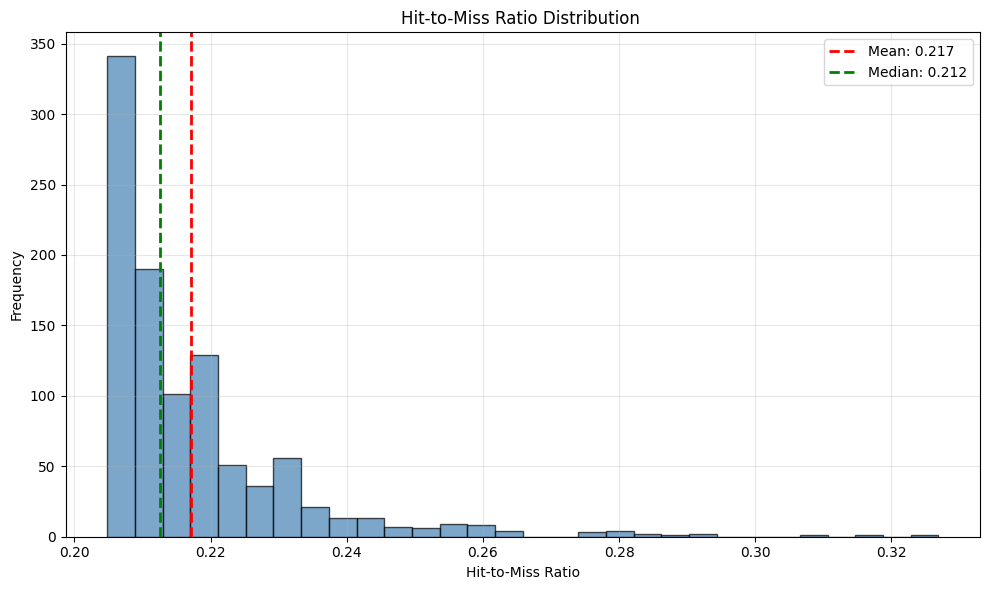

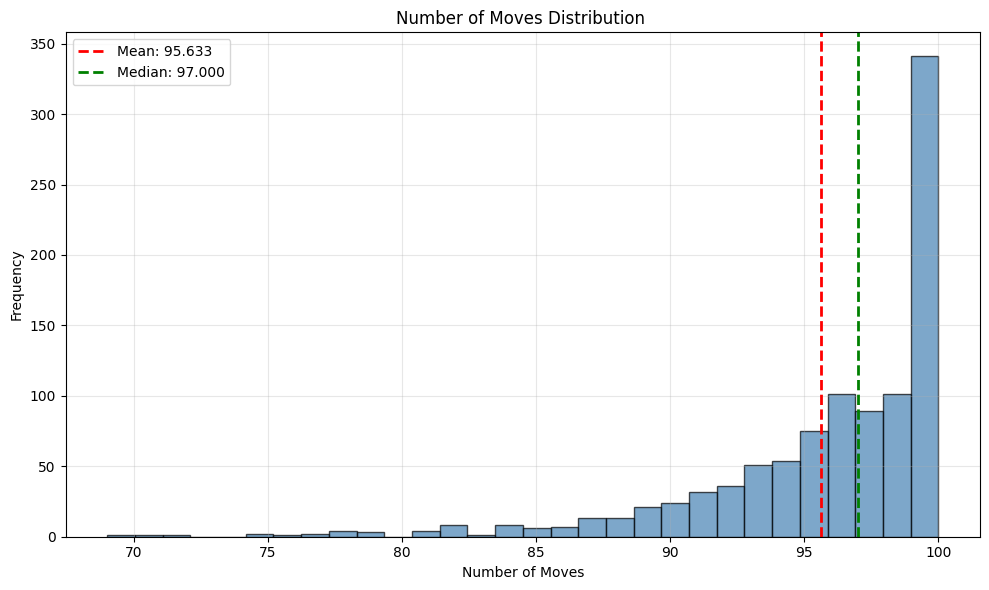

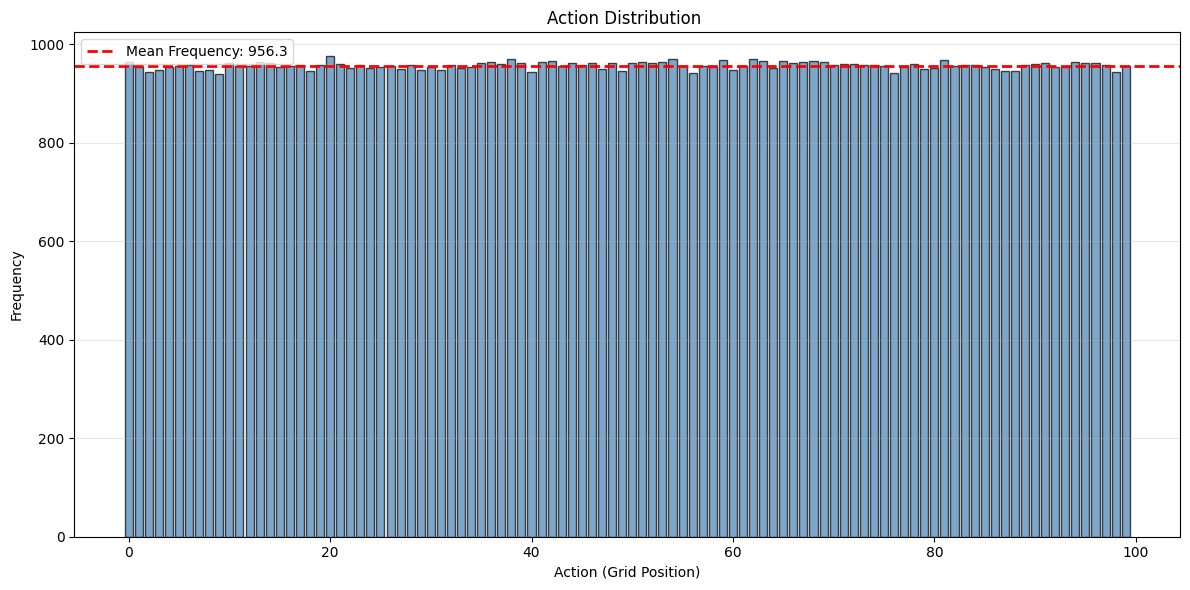

Random agent results: 
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 78633, 'average-hit-to-miss-ratio': 0.2161942187122455, 'win_rate': 1.0, 'avg_steps': 95.633, 'avg_reward': 302.2883999995522, 'action_distribution_samples': [{36: 1, 37: 1, 61: 1, 86: 1, 28: 1, 20: 1, 45: 1, 12: 1, 55: 1, 30: 1, 62: 1, 3: 1, 34: 1, 40: 1, 78: 1, 18: 1, 87: 1, 95: 1, 7: 1, 39: 1, 68: 1, 90: 1, 94: 1, 27: 1, 54: 1, 60: 1, 47: 1, 70: 1, 50: 1, 51: 1, 89: 1, 53: 1, 79: 1, 99: 1, 35: 1, 52: 1, 73: 1, 43: 1, 44: 1, 57: 1, 14: 1, 48: 1, 65: 1, 91: 1, 8: 1, 75: 1, 9: 1, 59: 1, 5: 1, 21: 1, 19: 1, 42: 1, 11: 1, 98: 1, 10: 1, 33: 1, 23: 1, 74: 1, 17: 1, 67: 1, 66: 1, 69: 1, 22: 1, 4: 1, 63: 1, 26: 1, 32: 1, 56: 1, 82: 1, 46: 1, 83: 1, 16: 1, 31: 1, 71: 1, 41: 1, 2: 1, 77: 1, 96: 1, 13: 1, 0: 1, 84: 1, 15: 1, 49: 1, 81: 1, 85: 1, 1: 1, 80: 1, 38: 1, 24: 1, 76: 1, 72: 1, 29: 1, 25: 1, 88: 1, 92: 1, 6: 1}, {34: 1, 8: 1, 4: 1, 73: 1, 82: 1, 50: 1, 24: 1, 65: 1, 95: 1, 19: 1, 93: 1, 0: 1, 91: 1

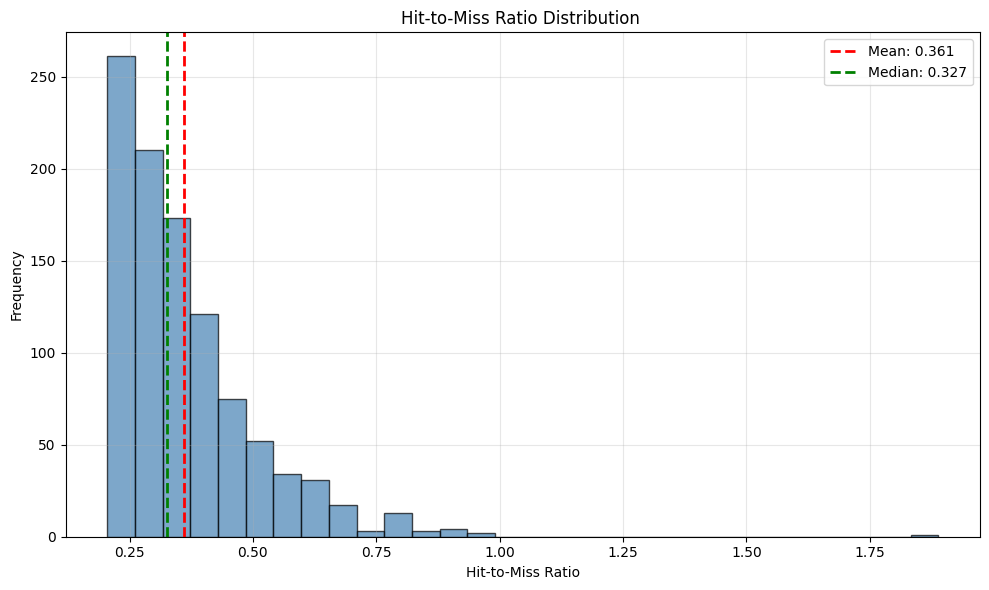

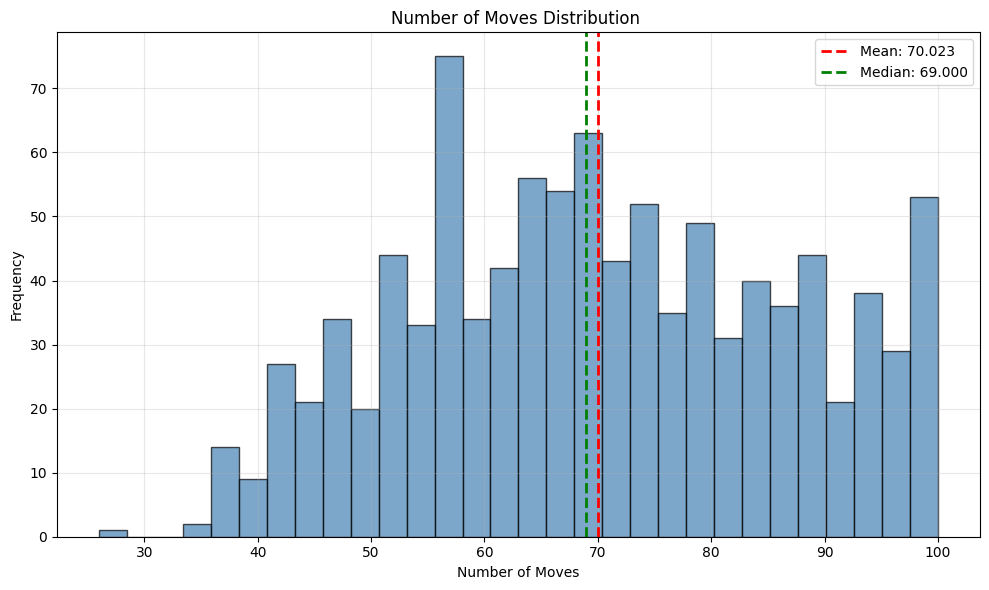

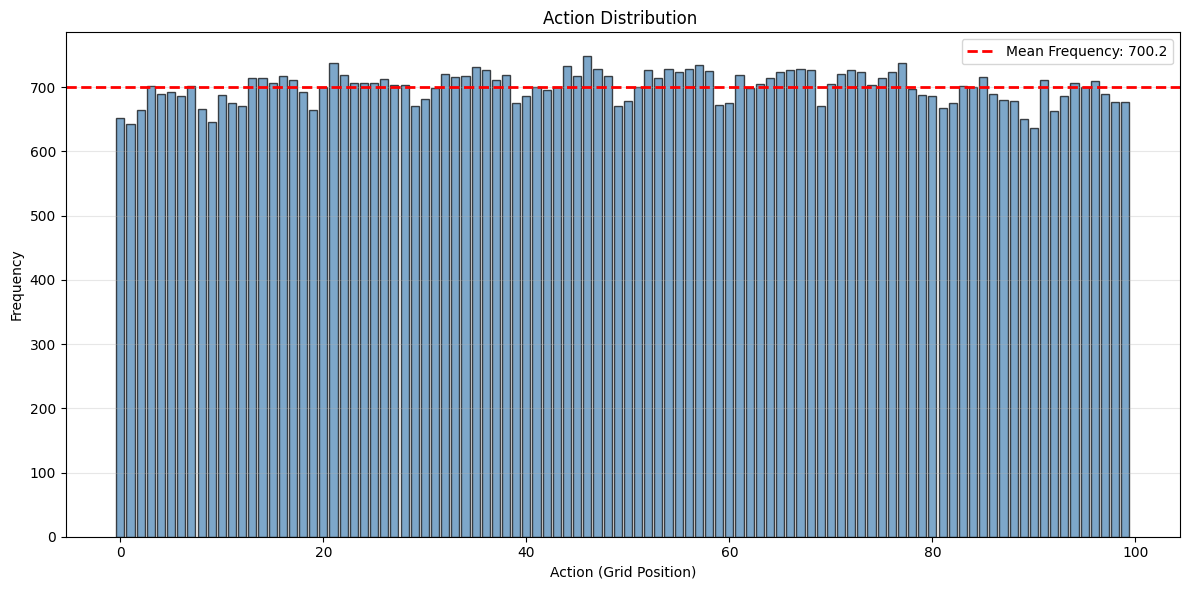

Heuristic agent results: 
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 53023, 'average-hit-to-miss-ratio': 0.3206155819172812, 'win_rate': 1.0, 'avg_steps': 70.023, 'avg_reward': 344.4303999996594, 'action_distribution_samples': [{28: 1, 85: 1, 73: 1, 25: 1, 57: 1, 58: 1, 56: 1, 67: 1, 77: 1, 47: 1, 37: 1, 27: 1, 29: 1, 92: 1, 98: 1, 33: 1, 8: 1, 93: 1, 53: 1, 71: 1, 17: 1, 13: 1, 21: 1, 31: 1, 43: 1, 55: 1, 54: 1, 65: 1, 75: 1, 45: 1, 74: 1, 78: 1, 16: 1, 70: 1, 4: 1, 63: 1, 15: 1, 30: 1, 72: 1, 82: 1, 62: 1, 52: 1, 42: 1, 32: 1, 99: 1, 97: 1, 96: 1, 95: 1, 38: 1, 87: 1, 61: 1, 35: 1, 48: 1, 5: 1, 9: 1, 3: 1, 59: 1, 44: 1, 80: 1, 90: 1, 10: 1, 60: 1, 50: 1, 40: 1}, {63: 1, 48: 1, 7: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 52: 1, 37: 1, 19: 1, 11: 1, 92: 1, 18: 1, 15: 1, 33: 1, 64: 1, 20: 1, 29: 1, 28: 1, 27: 1, 26: 1, 25: 1, 68: 1, 65: 1, 36: 1, 79: 1, 39: 1, 76: 1, 3: 1, 94: 1, 82: 1, 45: 1, 89: 1, 74: 1, 81: 1, 93: 1, 84: 1, 85: 1, 86: 1, 87: 1, 83: 1, 34:

In [79]:
# evaluate hardcoded agents

NUM_GAMES = 1000

env = gym.make('Battleship-v0', board_size=(10, 10), reward_dictionary=hyperparameters['rewards'])

random_agent = RandomAgent(skip_invalid_actions=True)

# 1000 games with action masking and 1000 without action masking
random_agent_results = run_games(random_agent, env, num_games=NUM_GAMES, mask=False, root_dir="./hardcoded_models/random_agent")
print("Random agent results: ")
print(random_agent_results)

env.reset()
heuristic_agent = HeuristicAgent(env, skip_invalid_actions=True)
heuristic_agent_results = run_games(heuristic_agent, env, num_games=NUM_GAMES, mask=False, root_dir="./hardcoded_models/heuristic_agent")

print("Heuristic agent results: ")
print(heuristic_agent_results)

with open (f"./hardcoded_models/random_agent/random_agent_results.txt", "a") as f:
    f.write("\t" + str(random_agent_results) + "\n")
    f.flush()

with open (f"./hardcoded_models/heuristic_agent/heuristic_agent_results.txt", "a") as f:
    f.write("\t" + str(heuristic_agent_results) + "\n")
    f.flush()